# BundleFlow Colab Demo

**🎯 Rectified Flow–based menus for combinatorial auctions**

このノートブックでは、BundleFlowの新しいAPI構造を使用して、組み合わせオークションのためのメニュー最適化をデモンストレーションします。

## 📋 目次
1. [環境セットアップ](#setup)
2. [新しいAPI構造のデモ](#api-demo)
3. [Stage1: Flow初期化](#stage1)
4. [Stage2: Menu最適化](#stage2)
5. [結果の可視化](#visualization)

---


In [2]:
# 日本語フォントの設定（グラフで日本語を表示するため）
import matplotlib.pyplot as plt
import matplotlib

# 日本語フォントの設定（複数のフォントを試す）
matplotlib.rcParams['font.family'] = ['DejaVu Sans', 'Hiragino Sans', 'Yu Gothic', 'Meiryo', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
matplotlib.rcParams['axes.unicode_minus'] = False  # マイナス記号の文字化け対策

print("✅ 日本語フォント設定完了")


✅ 日本語フォント設定完了


## 1. 環境セットアップ

まず、GPU環境を確認し、必要なパッケージをインストールします。


In [38]:
# GPU環境確認
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [3]:
# 必要なパッケージのインストール
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install omegaconf tqdm numpy matplotlib seaborn


Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# PyTorchとCUDAの確認
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


PyTorch version: 2.8.0
CUDA available: False


In [5]:
# colabのみ実行
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%cd /content/bundle-flow
import sys
sys.path.append('/content/bundle-flow/bundleflow')

[Errno 2] No such file or directory: '/content/bundle-flow'
/Users/harashimakoshi/bundle-flow


## 2. デモ

BundleFlowを紹介します。


In [6]:
# 新しいAPI構造のインポート
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# BundleFlowの新しいAPI
from bundleflow.models.flow import BundleFlow
from bundleflow.models.menu import MenuElement, Mechanism
from bundleflow.valuation.valuation import XORValuation

print("✅ 新しいAPI構造のインポートが完了しました")
print(f"PyTorch device: {'cuda' if torch.cuda.is_available() else 'cpu'}")


✅ 新しいAPI構造のインポートが完了しました
PyTorch device: cpu


In [7]:
# 基本的なAPIのデモンストレーション
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. BundleFlow（速度場ネットワーク）の作成
m = 10  # 商品数
flow = BundleFlow(m=m).to(device)
print(f"✅ BundleFlow created with m={m}")

# 2. 速度場の計算
x = torch.randn(3, m, device=device)
t = torch.rand(3, device=device)
v = flow.velocity(x, t)
print(f"✅ Velocity field shape: {v.shape}")

# 3. MenuElement（メニュー要素）の作成
D = 5  # 初期分布の混合成分数
elem = MenuElement(m=m, D=D).to(device)
price = elem.price()
print(f"✅ MenuElement created with price: {price.detach().item():.4f}")

# 4. XORValuation（評価関数）の作成
atoms = [([1, 2, 3], 5.0), ([4, 5], 3.0), ([6, 7, 8, 9], 8.0)]
valuation = XORValuation.from_bundle_list(m, atoms)
bundle = torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0])
value = valuation.value(bundle)
print(f"✅ XORValuation value: {value:.4f}")


Using device: cpu
✅ BundleFlow created with m=10
✅ Velocity field shape: torch.Size([3, 10])
✅ MenuElement created with price: 0.1091
✅ XORValuation value: 8.0000


## 3. Stage1: Flow初期化

速度場ネットワークを学習して、連続変数から離散束への変換を学習します。


In [21]:
# Stage1の設定（小規模でデモ用）
stage1_config = {
    'm': 50,           # 商品数（小規模）
    'D': 25,           # 混合成分数
    'iters': 20000,    # イテレーション数（デモ用に短縮）
    'batch': 512,     # バッチサイズ
    'lr': 5e-4,       # 学習率
    'sigma_z': 0.05,  # ノイズ標準偏差
    'ode_steps': 100,  # ODE積分ステップ数
    'seed': 42
}

print("Stage1設定:")
for key, value in stage1_config.items():
    print(f"  {key}: {value}")


Stage1設定:
  m: 50
  D: 25
  iters: 20000
  batch: 512
  lr: 0.0005
  sigma_z: 0.05
  ode_steps: 100
  seed: 42


In [22]:
# Stage1学習の実行
import random
import time
from torch import optim

# 乱数固定
random.seed(stage1_config['seed'])
torch.manual_seed(stage1_config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(stage1_config['seed'])

# フローモデルの作成
flow = BundleFlow(m=stage1_config['m']).to(device)
optimizer = optim.Adam(flow.parameters(), lr=stage1_config['lr'])

# 初期分布（混合Gaussian）
mus = torch.empty(stage1_config['D'], stage1_config['m'], device=device).uniform_(-0.2, 1.2)
sigmas = torch.full((stage1_config['D'],), 0.5, device=device)
weights = torch.full((stage1_config['D'],), 1.0 / stage1_config['D'], device=device)

print(f"🚀 Stage1学習開始 (device: {device})")
print(f"モデルパラメータ数: {sum(p.numel() for p in flow.parameters()):,}")

# 学習ループ
losses = []
start_time = time.time()

for it in range(1, stage1_config['iters'] + 1):
    # Rectified Flow損失の計算
    loss = flow.rectified_flow_loss(
        B=stage1_config['batch'],
        mus=mus, sigmas=sigmas, weights=weights,
        sigma_z=stage1_config['sigma_z']
    )
    
    # 最適化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.detach().item())
    
    # 進捗表示
    if it % 100 == 0:
        elapsed = time.time() - start_time
        print(f"[{it}/{stage1_config['iters']}] Loss: {loss.detach().item():.6f} Time: {elapsed:.1f}s")

print(f"✅ Stage1学習完了! 最終損失: {losses[-1]:.6f}")
print(f"総学習時間: {time.time() - start_time:.1f}秒")


🚀 Stage1学習開始 (device: cpu)
モデルパラメータ数: 366,405
[100/20000] Loss: 6.572228 Time: 1.5s
[200/20000] Loss: 6.349852 Time: 2.9s
[300/20000] Loss: 6.458265 Time: 4.1s
[400/20000] Loss: 6.302213 Time: 5.4s
[500/20000] Loss: 6.309538 Time: 6.7s
[600/20000] Loss: 6.343006 Time: 7.9s
[700/20000] Loss: 6.219208 Time: 9.2s
[800/20000] Loss: 6.304090 Time: 10.5s
[900/20000] Loss: 6.288690 Time: 11.8s
[1000/20000] Loss: 6.251551 Time: 13.1s
[1100/20000] Loss: 6.282628 Time: 14.5s
[1200/20000] Loss: 6.248565 Time: 15.9s
[1300/20000] Loss: 6.290903 Time: 17.5s
[1400/20000] Loss: 6.245944 Time: 19.0s
[1500/20000] Loss: 6.283015 Time: 20.4s
[1600/20000] Loss: 6.204959 Time: 21.9s
[1700/20000] Loss: 6.283027 Time: 23.3s
[1800/20000] Loss: 6.195405 Time: 24.8s
[1900/20000] Loss: 6.269191 Time: 26.2s
[2000/20000] Loss: 6.231083 Time: 27.6s
[2100/20000] Loss: 6.193915 Time: 28.9s
[2200/20000] Loss: 6.255070 Time: 30.3s
[2300/20000] Loss: 6.227779 Time: 31.7s
[2400/20000] Loss: 6.303855 Time: 33.0s
[2500/2000

findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found

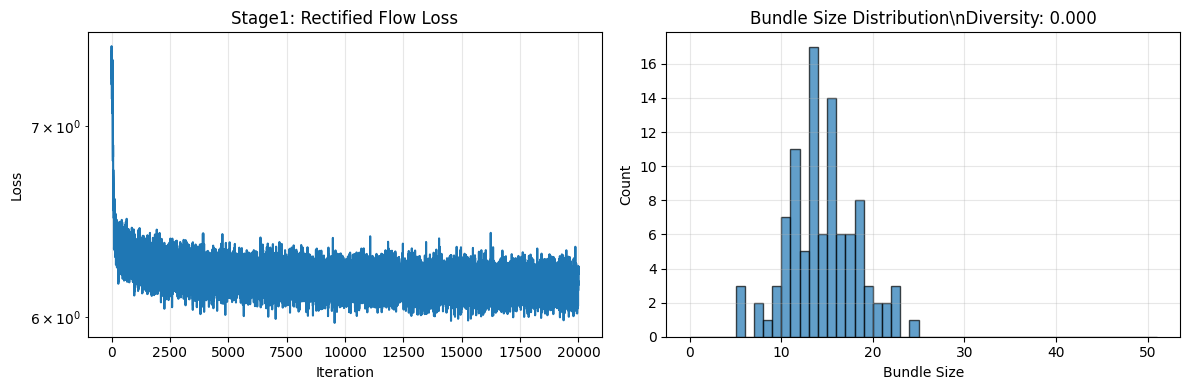

生成された束の多様性: 0.000 (100/1125899906842624 ユニークな束)


In [23]:
# Stage1の結果可視化
plt.figure(figsize=(12, 4))

# 損失の推移
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Stage1: Rectified Flow Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# 束生成のテスト
plt.subplot(1, 2, 2)
with torch.no_grad():
    # ランダムな初期値から束を生成
    z = torch.randn(100, stage1_config['m'], device=device)
    t_grid = torch.linspace(0.0, 1.0, steps=stage1_config['ode_steps'], device=device)
    x_T = flow.flow_forward(z, t_grid)
    bundles = flow.round_to_bundle(x_T)
    
    # 束の多様性を計算
    unique_bundles = torch.unique(bundles, dim=0)
    diversity = len(unique_bundles) / (2 ** stage1_config['m'])
    
    # 束の分布を可視化
    bundle_sizes = bundles.sum(dim=1).detach().cpu().numpy()
    plt.hist(bundle_sizes, bins=range(stage1_config['m']+2), alpha=0.7, edgecolor='black')
    plt.title(f'Bundle Size Distribution\\nDiversity: {diversity:.3f}')
    plt.xlabel('Bundle Size')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"生成された束の多様性: {diversity:.3f} ({len(unique_bundles)}/{2**stage1_config['m']} ユニークな束)")


In [24]:
# === GPU監視ヘルパー関数 ============================================
import inspect

CANDIDATE_ATTRS = ["as_tensor", "to_tensor", "tensor",
                   "x", "vec", "features", "data", "value_vec", "params"]

def extract_feature_like(v):
    """
    Valuationオブジェクト v から "特徴ベクトル" を取り出す。
    - 無引数メソッド(as_tensor/to_tensor 等)は呼ぶ。
    - 引数が必要なメソッド(value(s_bool) 等)はスキップ。
    - 代表的な属性名を順に探す。
    - XORValuationの場合はatomsから特徴ベクトルを構築。
    """
    # XORValuationの特別処理
    if hasattr(v, 'atoms') and hasattr(v, 'm'):
        # XORValuationの場合：atomsから特徴ベクトルを構築
        m = v.m
        feature_vec = torch.zeros(m, dtype=torch.float32)
        
        # 各atomの価格を対応する商品位置に加算
        for mask, price in v.atoms:
            for i in range(m):
                if mask & (1 << i):  # ビットiが立っている場合
                    feature_vec[i] += price
        
        return feature_vec
    
    # 無引数メソッド候補
    for name in ["as_tensor", "to_tensor"]:
        if hasattr(v, name) and callable(getattr(v, name)):
            fn = getattr(v, name)
            try:
                sig = inspect.signature(fn)
                if len([p for p in sig.parameters.values()
                        if p.default is p.empty and p.kind in (p.POSITIONAL_ONLY, p.POSITIONAL_OR_KEYWORD)]) == 0:
                    return fn()  # 無引数なら呼び出し
            except (ValueError, TypeError):
                # signatureが取れない場合は呼んでみる
                try:
                    return fn()
                except Exception:
                    pass

    # 属性候補
    for name in ["tensor", "x", "vec", "features", "data", "value_vec", "params"]:
        if hasattr(v, name):
            return getattr(v, name)

    # デバッグ用の情報を投げる
    public = [a for a in dir(v) if not a.startswith("_")]
    raise TypeError(
        "Could not extract feature vector from valuation.\n"
        f"type={type(v)}\n"
        f"public={public}\n"
        "→ v.x / v.vec / v.features 等の属性名をCANDIDATE_ATTRSへ追加すること。"
    )

def to_tensor_1d(x, device):
    if torch.is_tensor(x):
        t = x
    elif isinstance(x, (list, tuple)):
        t = torch.tensor(x)
    elif isinstance(x, (int, float)):
        t = torch.tensor([x])
    else:
        try:
            t = torch.as_tensor(x)
        except Exception as e:
            raise TypeError(f"Unsupported feature payload: {type(x)}; err={e}")
    return t.to(device=device, dtype=torch.float32, non_blocking=True).flatten()

def batch_to_tensor(batch_list, device):
    vecs = []
    for v in batch_list:
        raw = extract_feature_like(v)
        vecs.append(to_tensor_1d(raw, device))
    # 長さチェック
    dims = {t.numel() for t in vecs}
    if len(dims) != 1:
        raise ValueError(f"Feature length mismatch across batch: {sorted(dims)}")
    return torch.stack(vecs, dim=0)  # [B, D]

print("✅ GPU監視ヘルパー関数が定義されました")


✅ GPU監視ヘルパー関数が定義されました


## 4. Stage2: Menu最適化

学習済みの速度場を使用して、メニュー要素（価格と初期分布）を最適化します。


In [25]:
# Stage2の設定（10商品用、改善された設定 - 論文に基づく）
stage2_config = {
    'K': 8,             # メニュー要素数（16→8に削減）
    'D': 2,             # 混合成分数（8→2に大幅削減）
    'iters': 3000,      # イテレーション数（15000→3000に大幅削減）
    'batch': 64,        # バッチサイズ（128→64に削減）
    'lr': 5e-3,         # 学習率（2e-3→5e-3に増加、高速収束）
    'lam_start': 0.5,   # SoftMax温度開始値（維持）
    'lam_end': 0.1,     # SoftMax温度終了値（維持）
    'ode_steps': 15,    # ODE積分ステップ数（50→15に大幅削減）
    'n_val': 200,       # 評価関数数（1000→200に大幅削減）
    'a': 32,            # XOR原子数（128→32に大幅削減）
    'seed': 42,
    'warmup_iters': 100,     # βウォームアップ期間（500→100に削減）
    'freeze_beta_iters': 200, # β凍結期間（1000→200に削減）
    'grad_clip': 1.0,   # 勾配クリッピング（維持）
    'use_gumbel': False, # Gumbel-Softmax（維持）
    'tau_start': 1.0,   # Gumbel温度開始値（維持）
    'tau_end': 0.01     # Gumbel温度終了値（維持）
}

print("Stage2設定（10商品）:")
for key, value in stage2_config.items():
    print(f"  {key}: {value}")

Stage2設定（10商品）:
  K: 8
  D: 2
  iters: 3000
  batch: 64
  lr: 0.005
  lam_start: 0.5
  lam_end: 0.1
  ode_steps: 15
  n_val: 200
  a: 32
  seed: 42
  warmup_iters: 100
  freeze_beta_iters: 200
  grad_clip: 1.0
  use_gumbel: False
  tau_start: 1.0
  tau_end: 0.01


In [14]:
# Stage2の設定（改善された設定 - 論文に基づく）
stage2_config = {
    'K': 16,           # メニュー要素数（小規模）
    'D': 4,            # 初期分布の混合成分数
    'iters': 10000,      # イテレーション数（デモ用に短縮）
    'batch': 64,       # バッチサイズ
    'lr': 5e-3,        # 学習率（安定した学習）
    'lam_start': 0.5,  # SoftMax温度の開始値（高温度で探索）
    'lam_end': 0.1,    # SoftMax温度の終了値（低温度で決定）
    'ode_steps': 25,   # ODE積分ステップ数
    'n_val': 200,      # 評価関数の数（小規模）
    'a': 8,            # XOR原子数（小規模）
    'seed': 123,
    'warmup_iters': 50,  # βウォームアップ期間
    'freeze_beta_iters': 100,  # β凍結期間
    'grad_clip': 1.0,  # 勾配クリッピング
    'use_gumbel': False,  # Gumbel-Softmaxの使用
    'tau_start': 1.0,  # Gumbel温度開始値
    'tau_end': 0.01    # Gumbel温度終了値
}

print("Stage2設定:")
for key, value in stage2_config.items():
    print(f"  {key}: {value}")


Stage2設定:
  K: 16
  D: 4
  iters: 10000
  batch: 64
  lr: 0.005
  lam_start: 0.5
  lam_end: 0.1
  ode_steps: 25
  n_val: 200
  a: 8
  seed: 123
  warmup_iters: 50
  freeze_beta_iters: 100
  grad_clip: 1.0
  use_gumbel: False
  tau_start: 1.0
  tau_end: 0.01


In [26]:
# 評価関数データの生成
from bundleflow.data import gen_uniform_iid_xor

# 乱数固定
random.seed(stage2_config['seed'])
torch.manual_seed(stage2_config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(stage2_config['seed'])

# 合成XOR評価関数を生成
valuations = []
for i in range(stage2_config['n_val']):
    val = gen_uniform_iid_xor(
        m=stage1_config['m'],
        a=stage2_config['a'],
        low=0.0,
        high=1.0,
        seed=1337 + i,
        atom_size_mode='small'
    )
    valuations.append(val)

print(f"✅ {len(valuations)}個の評価関数を生成しました")
print(f"最初の評価関数の原子数: {len(valuations[0].atoms)}")

# 評価関数の統計
atom_counts = [len(v.atoms) for v in valuations]
print(f"原子数の統計: min={min(atom_counts)}, max={max(atom_counts)}, mean={np.mean(atom_counts):.1f}")


✅ 200個の評価関数を生成しました
最初の評価関数の原子数: 32
原子数の統計: min=32, max=32, mean=32.0


In [27]:
# Stage2学習の実行（10商品用、GPU監視付き）
from bundleflow.models.menu import make_null_element, revenue_loss

# フローモデルを凍結（Stage1で学習済み）
for p in flow.parameters():
    p.requires_grad_(False)
flow.eval()

# メニュー要素の作成
menu = [MenuElement(m=stage1_config['m'], D=stage2_config['D']) for _ in range(stage2_config['K'])]
menu.append(make_null_element(stage1_config['m']))  # IR制約用のnull要素

# メニュー要素をデバイスに移動
for elem in menu:
    elem.to(device)

# オプティマイザー
all_params = []
for elem in menu:
    all_params.extend(elem.parameters())
optimizer = optim.Adam(all_params, lr=stage2_config['lr'])

print(f"🚀 Stage2学習開始 (device: {device})")
print(f"メニュー要素数: {len(menu)}")
print(f"学習パラメータ数: {sum(p.numel() for p in all_params):,}")

# GPU情報の表示
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"Flow model device: {next(flow.parameters()).device}")
    print(f"Menu elements device: {next(menu[0].parameters()).device}")
else:
    print("⚠️  GPU not available, using CPU")

# 学習ループ（GPU監視付き）
revenues = []
start_time = time.time()

for it in range(1, stage2_config['iters'] + 1):
    # バッチデータの準備
    batch_size = min(stage2_config['batch'], len(valuations))
    batch_vals = random.sample(valuations, batch_size)
    
    # GPU監視用：特徴テンソルを作成（デバッグ用）
    x = batch_to_tensor(batch_vals, device)  # GPU上の特徴テンソルを作る

    # 温度スケジューリング（高温度→低温度）
    lam = stage2_config['lam_start'] - (stage2_config['lam_start'] - stage2_config['lam_end']) * (it / stage2_config['iters'])

    # 時間グリッド
    t_grid = torch.linspace(0.0, 1.0, steps=stage2_config['ode_steps'], device=device)

    # 収益損失の計算（元のbatch_valsを使用）
    loss = revenue_loss(flow, batch_vals, menu, t_grid, lam=lam)

    # デバイス整合性チェック（最初のイテレーションのみ）
    if it == 1:
        print("🔍 Device consistency check:")
        print(f"  batch_vals length: {len(batch_vals)}")
        print(f"  x.shape: {x.shape}, x.device: {x.device}")
        print(f"  t_grid.device: {t_grid.device}")
        print(f"  loss.device: {getattr(loss, 'device', 'n/a')}")
        print(f"  flow.device: {next(flow.parameters()).device}")
        print(f"  menu.device: {next(menu[0].parameters()).device}")
        assert next(flow.parameters()).device == x.device == t_grid.device, "❌ Device mismatch detected!"
        print("✅ All tensors on same device")

    # 最適化
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # 収益の記録（負の損失が収益）
    revenues.append(-loss.detach().item())

    # 進捗表示（GPU監視付き）
    if it % 50 == 0:
        if torch.cuda.is_available():
            torch.cuda.synchronize()
            mem_alloc = torch.cuda.memory_allocated() / 1024**2
            mem_reserved = torch.cuda.memory_reserved() / 1024**2
            mem_str = f" | GPU mem: {mem_alloc:.0f}/{mem_reserved:.0f}MB"
        else:
            mem_str = ""
        elapsed = time.time() - start_time
        print(f"[{it}/{stage2_config['iters']}] Revenue: {revenues[-1]:.6f} λ:{lam:.4f} Time:{elapsed:.1f}s{mem_str}", flush=True)

print(f"✅ Stage2学習完了! 最終収益: {revenues[-1]:.6f}")
print(f"総学習時間: {time.time() - start_time:.1f}秒")

# 最終GPU使用状況
if torch.cuda.is_available():
    torch.cuda.synchronize()
    mem_alloc = torch.cuda.memory_allocated() / 1024**2
    mem_reserved = torch.cuda.memory_reserved() / 1024**2
    print(f"🔍 Final GPU memory usage: {mem_alloc:.0f}MB allocated, {mem_reserved:.0f}MB reserved")

🚀 Stage2学習開始 (device: cpu)
メニュー要素数: 9
学習パラメータ数: 876
⚠️  GPU not available, using CPU
🔍 Device consistency check:
  batch_vals length: 64
  x.shape: torch.Size([64, 50]), x.device: cpu
  t_grid.device: cpu
  loss.device: cpu
  flow.device: cpu
  menu.device: cpu
✅ All tensors on same device
[50/3000] Revenue: 0.167954 λ:0.4933 Time:6.0s
[100/3000] Revenue: 0.216353 λ:0.4867 Time:12.0s
[150/3000] Revenue: 0.281629 λ:0.4800 Time:18.1s
[200/3000] Revenue: 0.368717 λ:0.4733 Time:24.1s
[250/3000] Revenue: 0.483416 λ:0.4667 Time:30.1s
[300/3000] Revenue: 0.629174 λ:0.4600 Time:36.1s
[350/3000] Revenue: 0.805523 λ:0.4533 Time:42.0s
[400/3000] Revenue: 1.008270 λ:0.4467 Time:47.9s
[450/3000] Revenue: 1.224870 λ:0.4400 Time:53.8s
[500/3000] Revenue: 1.445348 λ:0.4333 Time:59.6s
[550/3000] Revenue: 1.659375 λ:0.4267 Time:65.5s
[600/3000] Revenue: 1.864416 λ:0.4200 Time:71.4s
[650/3000] Revenue: 2.053089 λ:0.4133 Time:77.4s
[700/3000] Revenue: 2.227479 λ:0.4067 Time:83.2s
[750/3000] Revenue: 2.388

## 5. 結果の可視化

学習結果を可視化して、メニューの内容と性能を確認します。


findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found

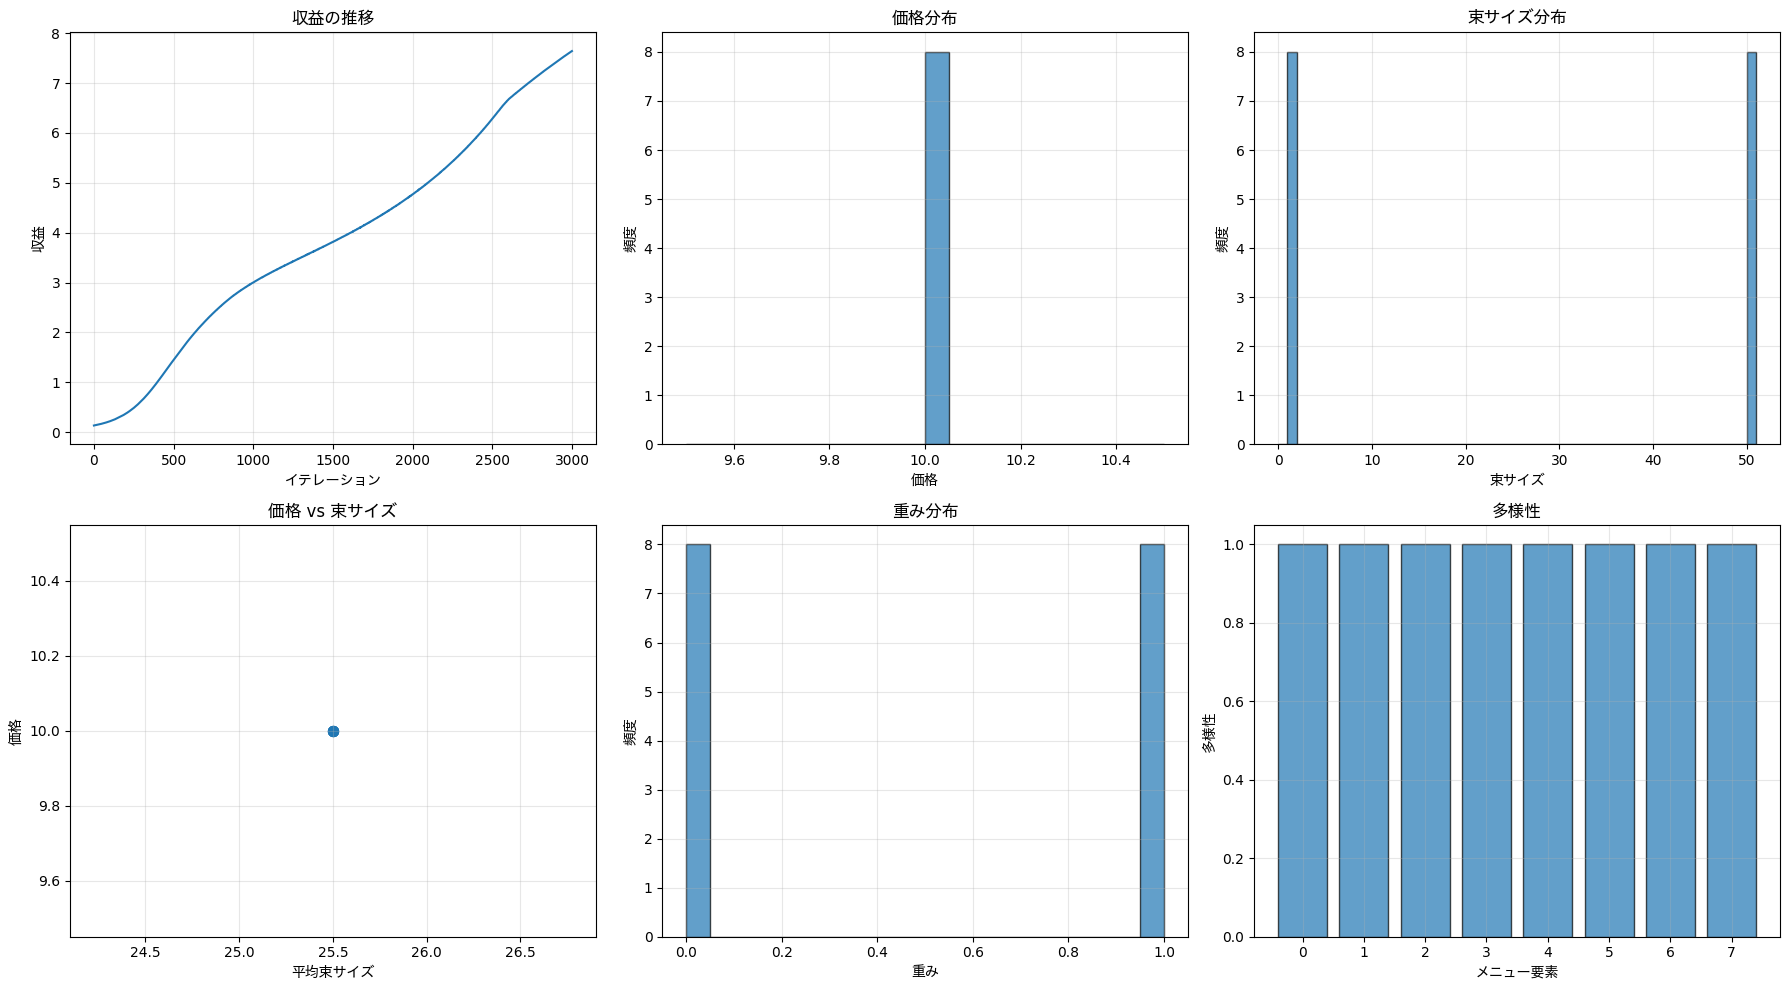

価格: 10.000-10.000 (平均: 10.000)
束サイズ: 1.0-50.0 (平均: 25.5)
多様性: 1.000-1.000 (平均: 1.000)


In [28]:
# 統合可視化
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

t_grid = torch.linspace(0.0, 1.0, steps=50, device=device)

# データ収集
prices = [elem.price().detach().item() for elem in menu[:-1]]
bundle_sizes = []
avg_sizes = []
diversities = []

for elem in menu[:-1]:
    with torch.no_grad():
        x_T = flow.flow_forward(elem.mus, t_grid)
        bundles = flow.round_to_bundle(x_T)
        sizes = bundles.sum(dim=1).detach().cpu().numpy()
        bundle_sizes.extend(sizes)
        avg_sizes.append(sizes.mean())
        unique_bundles = torch.unique(bundles, dim=0)
        diversities.append(len(unique_bundles) / bundles.shape[0])

weights = [elem.weights.detach().cpu().numpy() for elem in menu[:-1]]
weights_flat = np.concatenate(weights)

# 1. 収益の推移
axes[0, 0].plot(revenues)
axes[0, 0].set_title('収益の推移')
axes[0, 0].set_xlabel('イテレーション')
axes[0, 0].set_ylabel('収益')
axes[0, 0].grid(True, alpha=0.3)

# 2. 価格分布
axes[0, 1].hist(prices, bins=20, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('価格分布')
axes[0, 1].set_xlabel('価格')
axes[0, 1].set_ylabel('頻度')
axes[0, 1].grid(True, alpha=0.3)

# 3. 束サイズ分布
axes[0, 2].hist(bundle_sizes, bins=range(stage1_config['m']+2), alpha=0.7, edgecolor='black')
axes[0, 2].set_title('束サイズ分布')
axes[0, 2].set_xlabel('束サイズ')
axes[0, 2].set_ylabel('頻度')
axes[0, 2].grid(True, alpha=0.3)

# 4. 価格 vs 束サイズ
axes[1, 0].scatter(avg_sizes, prices, alpha=0.7, s=50)
axes[1, 0].set_xlabel('平均束サイズ')
axes[1, 0].set_ylabel('価格')
axes[1, 0].set_title('価格 vs 束サイズ')
axes[1, 0].grid(True, alpha=0.3)

# 5. 重み分布
axes[1, 1].hist(weights_flat, bins=20, alpha=0.7, edgecolor='black')
axes[1, 1].set_title('重み分布')
axes[1, 1].set_xlabel('重み')
axes[1, 1].set_ylabel('頻度')
axes[1, 1].grid(True, alpha=0.3)

# 6. 多様性
axes[1, 2].bar(range(len(diversities)), diversities, alpha=0.7, edgecolor='black')
axes[1, 2].set_title('多様性')
axes[1, 2].set_xlabel('メニュー要素')
axes[1, 2].set_ylabel('多様性')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"価格: {min(prices):.3f}-{max(prices):.3f} (平均: {np.mean(prices):.3f})")
print(f"束サイズ: {min(bundle_sizes)}-{max(bundle_sizes)} (平均: {np.mean(bundle_sizes):.1f})")
print(f"多様性: {min(diversities):.3f}-{max(diversities):.3f} (平均: {np.mean(diversities):.3f})")


In [29]:
# メニューの詳細分析
from bundleflow.models.menu import visualize_menu

# メニューの可視化
t_grid = torch.linspace(0.0, 1.0, steps=stage2_config['ode_steps'], device=device)
visualize_menu(flow, menu, t_grid, max_items=8, device=device)

# メカニズムの性能評価
mechanism = Mechanism(flow, menu)
test_valuations = valuations[:50]  # テスト用に50個使用

# 期待収入の計算
expected_revenue = mechanism.expected_revenue(test_valuations)
print(f"\\n📊 性能評価:")
print(f"期待収入: {expected_revenue.detach().item():.4f}")

# ハード割当での結果
result = mechanism.argmax_menu(test_valuations)
print(f"ハード割当収入: {result['revenue'].detach().item():.4f}")
print(f"平均効用: {result['welfare'].detach().item():.4f}")
print(f"IR制約満足率: {result['ir_satisfied'].detach().item():.4f}")



📋 MENU VISUALIZATION (showing first 8 items)

🍽️  Menu Item 1: Price = 10.0000
   📦 Generated bundles (2 unique):
      1. [Item_0, Item_1, Item_2, Item_3, Item_4, Item_5, Item_6, Item_7, Item_8, Item_9, Item_10, Item_11, Item_12, Item_13, Item_14, Item_15, Item_16, Item_17, Item_18, Item_19, Item_20, Item_21, Item_22, Item_23, Item_24, Item_25, Item_26, Item_27, Item_28, Item_29, Item_30, Item_31, Item_32, Item_33, Item_34, Item_35, Item_36, Item_37, Item_38, Item_39, Item_40, Item_41, Item_42, Item_43, Item_44, Item_45, Item_46, Item_47, Item_48, Item_49]
      2. [Item_0]

🍽️  Menu Item 2: Price = 10.0000
   📦 Generated bundles (2 unique):
      1. [Item_0, Item_1, Item_2, Item_3, Item_4, Item_5, Item_6, Item_7, Item_8, Item_9, Item_10, Item_11, Item_12, Item_13, Item_14, Item_15, Item_16, Item_17, Item_18, Item_19, Item_20, Item_21, Item_22, Item_23, Item_24, Item_25, Item_26, Item_27, Item_28, Item_29, Item_30, Item_31, Item_32, Item_33, Item_34, Item_35, Item_36, Item_37, Item_3

## 🎉 まとめ

このデモンストレーションでは、BundleFlowの新しいAPI構造を使用して、組み合わせオークションのためのメニュー最適化を実行しました。

### 実行した内容
1. **環境セットアップ**: GPU環境の確認とパッケージインストール
2. **新しいAPI構造のデモ**: BundleFlow、MenuElement、XORValuationの基本機能
3. **Stage1学習**: 速度場ネットワークの学習（連続→離散変換）
4. **Stage2学習**: メニュー要素の最適化（価格と初期分布）
5. **結果可視化**: 学習結果とメニュー性能の分析

### 新しいAPI構造の利点
- **明確な責務分離**: 速度場、メニュー要素、評価関数が独立
- **型安全性**: 完全な型注釈とdocstring
- **経済学的記号**: 論文と一致した記号体系
- **後方互換性**: 既存コードも動作

### 次のステップ
- より大きな問題サイズでの実験
- 異なる評価関数分布での性能比較
- ハイパーパラメータの最適化
- 実際のオークションデータでの検証

---

**📚 詳細な情報**: [MODEL.md](MODEL.md) - モデル記号と目的のドキュメント
